In [1]:
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import sys
import itertools
from collections import namedtuple, defaultdict
from pathlib import Path

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 1
%aimport analyze

with open('plots/style.json') as f:
    mpl.rcParams.update(json.load(f))

# Results

## Wildstyle failures

In [2]:
ws = analyze.Analysis('results/wildstyle')
print(ws)

Analysis for Celeritas v0.4.0-rc.2 on wildstyle


In [3]:
ftab = analyze.make_failure_table(ws.failures())
ftab.to_frame()

,Failure
cms2018+field+msc/vecgeom+cpu (0),internal assertion failed: `track.make_geo_vie...


In [5]:
ftab.to_dict()

{'cms2018+field+msc/vecgeom+cpu (0)': 'internal assertion failed: `track.make_geo_view().pos() != orig_pos` at `PropagationApplier.hh:116`'}

Unconverged tracks (from runs that didn't fail):

In [4]:
summed = analyze.summarize_instances(ws.result[['unconverged']])
unconv = summed[('unconverged', 'mean')]
unconv[unconv > 0].unstack('arch') 

,arch
problem,geo


## Summit

In [14]:
summit = analyze.Analysis('results/summit')
print(summit)

Analysis for Celeritas v0.4.0-rc.2.17+fa123c7fe on summit


Average number of unconverged tracks:

In [8]:
unconv = analyze.summarize_instances(summit.result['unconverged'])['mean']
unconv[unconv > 0].unstack('arch') 

,arch
problem,geo


## Crusher

In [9]:
def get_step_times(results):
    new_idx = []
    times = []
    for i in results.index:
        try:
            outp = results.load_results(i, 0)
            step_times = analyze.StepTimeGetter(outp, stream=0)()
        except Exception:
            continue
        times.append([step_times[i] for i in range(2)])
        new_idx.append(i)
    return pd.DataFrame(times, index=pd.MultiIndex.from_tuples(new_idx))

In [20]:
crusher = analyze.Analysis('results/crusher')
print(crusher)

Analysis for Celeritas v0.4.0-rc.2.4+affc7bb17 on crusher


In [21]:
analyze.get_device_properties(crusher)

{'can_map_host_memory': True,
 'capability_major': 9,
 'capability_minor': 0,
 'clock_rate': 1700000,
 'device_id': 0,
 'eu_per_cu': 4,
 'max_blocks_per_grid': 2147483647,
 'max_cache_size': 8388608,
 'max_threads_per_block': 1024,
 'max_threads_per_cu': 2048,
 'memory_clock_rate': 1600000,
 'multiprocessor_count': 110,
 'name': 'gfx90a',
 'platform': 'hip',
 'regs_per_block': 65536,
 'shared_mem_per_block': 65536,
 'threads_per_warp': 64,
 'total_const_mem': 2147483647,
 'total_global_mem': 68702699520}

## Frontier

In [25]:
frontier = analyze.Analysis('results/frontier')
print(frontier)

Analysis for Celeritas v0.4.0-rc.2.4+affc7bb17 on frontier


In [12]:
frontier_rates = analyze.calc_event_rate(frontier)
summit_rates = analyze.calc_event_rate(summit, summit.summed.loc[frontier_rates.index])

counts = {
    ('summit', 'cpu'): 7,
    ('summit', 'gpu'): 1,
    ('frontier', 'cpu'): 7,
    ('frontier', 'gpu'): 1,
}

In [13]:
(frontier_rates['mean'] / summit_rates['mean']).unstack()

,arch,cpu,gpu,gpu+sync
problem,geo,,,
simple-cms+field,orange,1.859090,0.769070,NaN
simple-cms+field+msc,orange,1.944670,0.820616,NaN
simple-cms+msc,orange,1.870205,0.853647,NaN
testem15,orange,1.755824,0.799741,NaN
testem15+field,orange,1.866668,0.875827,0.878627
testem15+field+msc,orange,1.903381,0.911272,NaN
testem3-flat,orange,1.767941,0.725712,NaN
testem3-flat+field,orange,1.860801,0.739295,NaN
testem3-flat+field+msc,orange,1.919230,0.719573,0.723578


## Perlmutter

In [2]:
perlmutter = analyze.Analysis('results/perlmutter')
print(perlmutter)

Analysis for Celeritas v0.4.0 on perlmutter


In [3]:
testem3 = perlmutter.result.xs('testem3-flat+field+msc', level='problem').xs('orange', level='geo')
event_per_sec = testem3['avg_event_per_time'].unstack('arch').describe().loc['mean']
del event_per_sec['gpu+sync']

In [4]:
event_per_sec

arch
cpu    0.090867
gpu    1.619334
Name: mean, dtype: float64

In [10]:
cores_per_job = pd.Series([16, 1], index=event_per_sec.index)
watt_per_card = pd.Series([280, 250], index=event_per_sec.index)
cores_per_card = pd.Series([64, 1], index=event_per_sec.index) # AMD hardware cores, *NOT* threads
watt_per_core = watt_per_card / cores_per_card
watt_per_job = watt_per_core * cores_per_job
event_per_joule = event_per_sec / watt_per_job

In [11]:
event_per_joule

arch
cpu    0.001298
gpu    0.006477
dtype: float64

In [12]:
event_per_joule['gpu'] / event_per_joule['cpu']

4.989850269771324

In [13]:
event_per_wh = event_per_joule * 60 * 60
event_per_wh

arch
cpu     4.673169
gpu    23.318415
dtype: float64

# Occupancy

In [26]:
problem = "testem3-flat"
kernel_stats = {
    "cuda/vecgeom": analyze.load_kernels(summit, problem, "vecgeom"),
    "cuda/orange": analyze.load_kernels(summit, problem, "orange"),
    "hip/orange": analyze.load_kernels(frontier, problem, "orange"),
}
ksdf = analyze.kernel_stats_dataframe(kernel_stats)

In [27]:
ksdf[ksdf['local_mem'] > 64]

const_mem    heap_size  local_mem  \
arch geo     name                                                   
cuda vecgeom scat-rayleigh          20776      8388608        104   
     orange  initialize-tracks          0      8388608        160   
             photoel-livermore          0      8388608         80   
             scat-rayleigh              0      8388608        104   
             geo-boundary               0      8388608        176   
hip  orange  initialize-tracks          0  68702699520        120   
             geo-boundary               0  68702699520        128   

                                max_blocks_per_cu  max_threads_per_block  \
arch geo     name                                                          
cuda vecgeom scat-rayleigh                      4                    256   
     orange  initialize-tracks                  5                    256   
             photoel-livermore                  3                    256   
             scat-rayleigh                      4                    256   
             geo-boundary                       4                    256   
hip  orange  initialize-tracks                  5                    256   
             geo-boundary                       5                    256   

                                max_warps_per_eu  num_regs  occupancy  \
arch geo     name                                                       
cuda vecgeom scat-rayleigh                    32        64      0.500   
     orange  initialize-tracks                40        48      0.625   
             photoel-livermore                24        68      0.375   
             scat-rayleigh                    32        63      0.500   
             geo-boundary                     32        64      0.500   
hip  orange  initialize-tracks                 5        86      0.625   
             geo-boundary                      5        90      0.625   

                                threads_per_block  kernel_index  register_mem  
arch geo     name                                                              
cuda vecgeom scat-rayleigh                    256            15           256  
     orange  initialize-tracks                256             1           192  
             photoel-livermore                256            12           272  
             scat-rayleigh                    256            15           252  
             geo-boundary                     256            17           256  
hip  orange  initialize-tracks                256             1           344  
             geo-boundary                     256            17           360

# Performance per core

In [47]:
frontier_rates.index

MultiIndex([(      'simple-cms+field', 'orange',      'cpu'),
            (      'simple-cms+field', 'orange',      'gpu'),
            (  'simple-cms+field+msc', 'orange',      'cpu'),
            (  'simple-cms+field+msc', 'orange',      'gpu'),
            (        'simple-cms+msc', 'orange',      'cpu'),
            (        'simple-cms+msc', 'orange',      'gpu'),
            (              'testem15', 'orange',      'cpu'),
            (              'testem15', 'orange',      'gpu'),
            (        'testem15+field', 'orange',      'cpu'),
            (        'testem15+field', 'orange',      'gpu'),
            (        'testem15+field', 'orange', 'gpu+sync'),
            (    'testem15+field+msc', 'orange',      'cpu'),
            (    'testem15+field+msc', 'orange',      'gpu'),
            (          'testem3-flat', 'orange',      'cpu'),
            (          'testem3-flat', 'orange',      'gpu'),
            (    'testem3-flat+field', 'orange',      'cpu'),
        

In [32]:
frontier_rates = analyze.calc_event_rate(frontier)

def calc_event_rate_with_index(analysis, idx):
    return analyze.calc_event_rate(analysis, analysis.summed.loc[idx])

rates = {
    "frontier": frontier_rates,
    "summit": calc_event_rate_with_index(summit, frontier_rates.index),
    "perlmutter": calc_event_rate_with_index(perlmutter, frontier_rates.index),
}

cpu_per_gpu = {
    "wildstyle": 32,
    "summit": 7,
    "frontier": 7,
    "crusher": 7,
    "perlmutter": 16,
}

In [33]:
gpu_per_machine = {
    "wildstyle": 2,
    "summit": 6,
    "frontier": 8,
    "crusher": 8,
    "perlmutter": 4,
}

In [40]:
def get_sm_count(analysis):
    return analyze.get_device_properties(analysis)["multiprocessor_count"]

analyses = {
    "summit": summit,
    "perlmutter": perlmutter,
    "frontier": frontier,
}

sm_per_gpu = {k: get_sm_count(v) for k, v in analyses.items()}

In [59]:
sm_per_gpu

{'summit': 80, 'perlmutter': 108, 'frontier': 110}

In [45]:
system_color = {
    "summit": "#7A954F",
    "frontier": "#BC5544",
    "perlmutter": "#3E92C7",
}

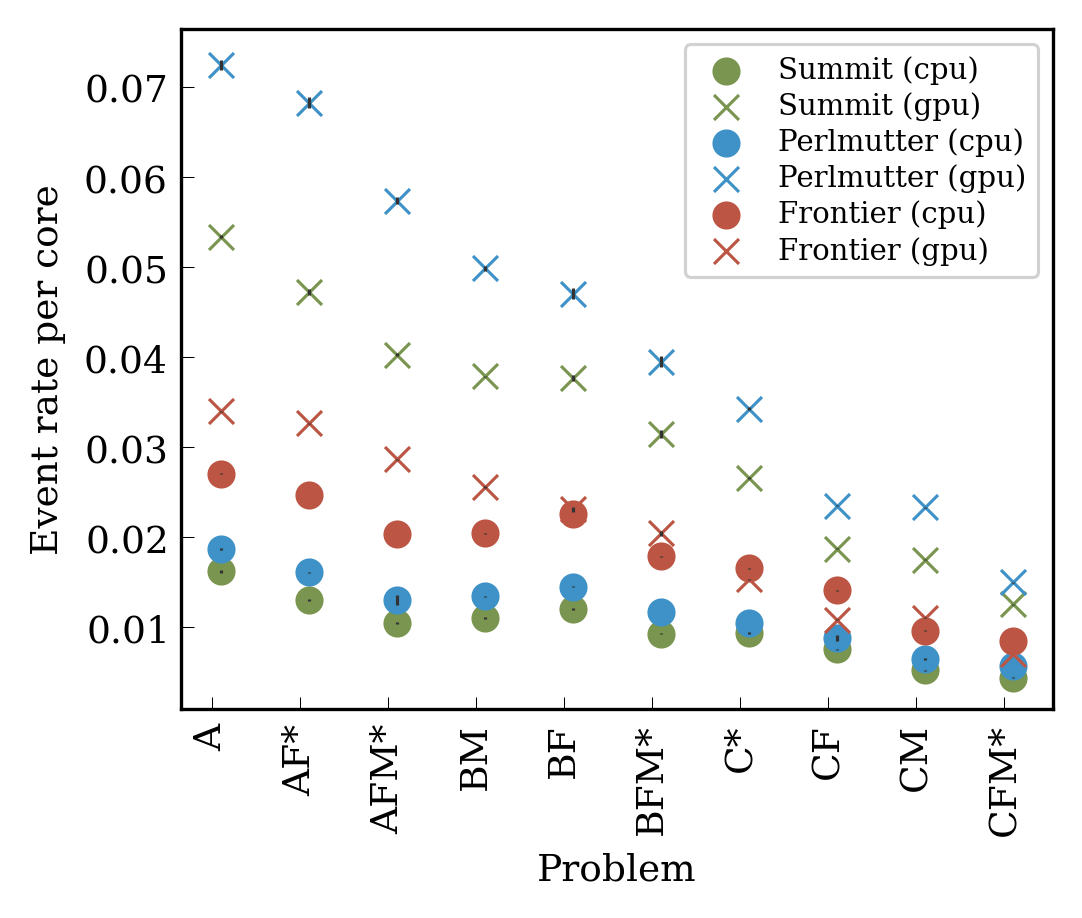

In [57]:
(fig, ax) = plt.subplots()
for k in analyses:
    for arch in ['cpu', 'gpu']:
        r = rates[k]
        v = r[r.index.get_level_values("arch") == arch]
        if arch == "cpu":
            v /= cpu_per_gpu[k]
        else:
            v /= sm_per_gpu[k]
        scat = analyses[k].plot_results(ax, v)
        for s in scat:
            s.set_color(system_color[k])
            s.set_label(f"{k.title()} ({arch})")
ax.legend()
ax.set_xlabel("Problem")
ax.set_ylabel("Event rate per core")
fig.savefig('event-per-core.png', dpi=150, transparent=False)